**Algorithme de détection de faux-billets**

In [1]:
readme = open("README.txt", "r")
contenu = readme.read()
print(contenu)

Projet: Mise en place d'un algorithme pour détecter les faux billets.

Ce projet consiste à mettre en place un algorithme permettant de distinguer les billets véridiques des billets contrefaits.

Ce projet a été réalisé en septembre 2019 durant ma formation à l'EDHEC au sein du Master Data Analytics & Artificial Intelligence.
Il avait les objectifs pédagogiques suivants: 
+ Balancer notre dataset avec l'algorithme SMOTE
+ Mise en place d'un algorithme de classification grâce à une régression logistique (évaluation: ROC/Matrice de confusion)
+ Utilisation de techniques de clustering (Classification hiérarchique, k-means).
+ Mise en place d'une analyse en Composantes Principales (ACP) pour représenter visuellement notre dataset.

Les données sont un dataset de données fictives contenant les caractéristiques géométriques de billets de banque.  
Pour chacun d'eux, nous connaissons :
+ La longueur du billet (en mm)
+ La hauteur du billet (mesurée sur le côté gauche, en mm)
+ La hauteur du b

# Description des données

## Imports

In [25]:
# Manipulation des données
import numpy as np
import pandas as pd
import math
# Statistiques
import statsmodels
from statsmodels.stats.weightstats import ztest
import scipy
from scipy.stats import norm
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import sklearn
from sklearn import decomposition, preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import skew, kurtosis
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from imblearn.over_sampling import SMOTE
# Graphiques
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns

## Importation des données

Notre base de travail.

In [26]:
df_ = pd.read_csv("billets.csv")
df_.head()

,is_genuine,length,height_left,height_right,margin_low,margin_up,diagonal
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


In [27]:
df_billet = pd.read_csv("billets.csv")
# On renomme les colonnes
nouveaux_noms_colonnes = {"is_genuine": "veridique", "length": "longueur",
                          "height_left": "hauteur_gauche", "height_right": "hauteur_droite",
                          "margin_low":"marge_inf","margin_up":"marge_sup","diagonal":"diagonale"}
df_billet.rename(columns=nouveaux_noms_colonnes, inplace=True)

df_billet.head(2)

,veridique,longueur,hauteur_gauche,hauteur_droite,marge_inf,marge_sup,diagonale
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29


## Descriptions rapides

* Notre variable **veridique** prend deux valeurs possibles.
  * La valeur **True** correspondant à un **billet véridique**.
  * La valeur **False** correspondant à un **billet non véridique**, c'est-à-dire un faux billet.

* **Nombre de billets véridiques**

In [28]:
# ou df_billet["veridique"].value_counts()
nb_veridique = np.sum(df_billet["veridique"])
print("Nous avons {} billets véridiques.".format(nb_veridique))

Nous avons 100 billets véridiques.


* **Nombre de billets non-véridiques**

In [29]:
nb_non_veridique = np.sum(~df_billet["veridique"])
print("Nous avons {} billets non-véridiques.".format(nb_non_veridique))

Nous avons 70 billets non-véridiques.


* **Moyenne de notre échantillon de billets véridiques**

In [30]:
moyenne_veridique = round((nb_veridique/(nb_veridique + nb_non_veridique))*100,2)
print("Notre échantillon a une moyenne de {}% billets véridiques.".format(moyenne_veridique))

Notre échantillon a une moyenne de 58.82% billets véridiques.


In [31]:
df_billet.describe().round(2)

,longueur,hauteur_gauche,hauteur_droite,marge_inf,marge_sup,diagonale
count,170.00,170.00,170.00,170.00,170.00,170.00
mean,171.94,104.07,103.93,4.61,3.17,112.57
std,0.31,0.30,0.33,0.70,0.24,0.92
min,171.04,103.23,103.14,3.54,2.27,109.97
25%,171.73,103.84,103.69,4.05,3.01,111.85
50%,171.94,104.06,103.95,4.45,3.17,112.84
75%,172.14,104.29,104.17,5.13,3.33,113.29
max,173.01,104.86,104.95,6.28,3.68,113.98


* Decription rapide des **variables**.
  * Observations:
        * Nous avons les données de 170 billets.
        * Les écarts types sont faibles.

In [32]:
df_billet.iloc[:,1:].corr().round(2)

,longueur,hauteur_gauche,hauteur_droite,marge_inf,marge_sup,diagonale
longueur,1.00,0.32,0.22,-0.18,-0.03,0.08
hauteur_gauche,0.32,1.00,0.73,0.42,0.32,-0.42
hauteur_droite,0.22,0.73,1.00,0.51,0.37,-0.42
marge_inf,-0.18,0.42,0.51,1.00,0.17,-0.64
marge_sup,-0.03,0.32,0.37,0.17,1.00,-0.53
diagonale,0.08,-0.42,-0.42,-0.64,-0.53,1.00


* Decription rapide des **corrélations**.  
NB: Le boléen *veridique* n'apparait pas.
  * Observations:
        * Corrélation positive importante (0.73) entre la hauteur droite et la hauteur gauche.
        * Corrélation négative modérée (-0.64) entre la marge inférieure et la diagonale.

In [33]:
# Les couleurs de nos billets
# Les billets véridiques en vert
# Les billets non véridiques en rouge
# Quand on utilise une palette
colors = ["medium green", "pale red"]
ma_palette = sns.xkcd_palette(colors)
# Quand on veut le nom d'une variable
vert = sns.xkcd_rgb["medium green"]  #39ad48
rouge = sns.xkcd_rgb["pale red"] #d9544d

C:\anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


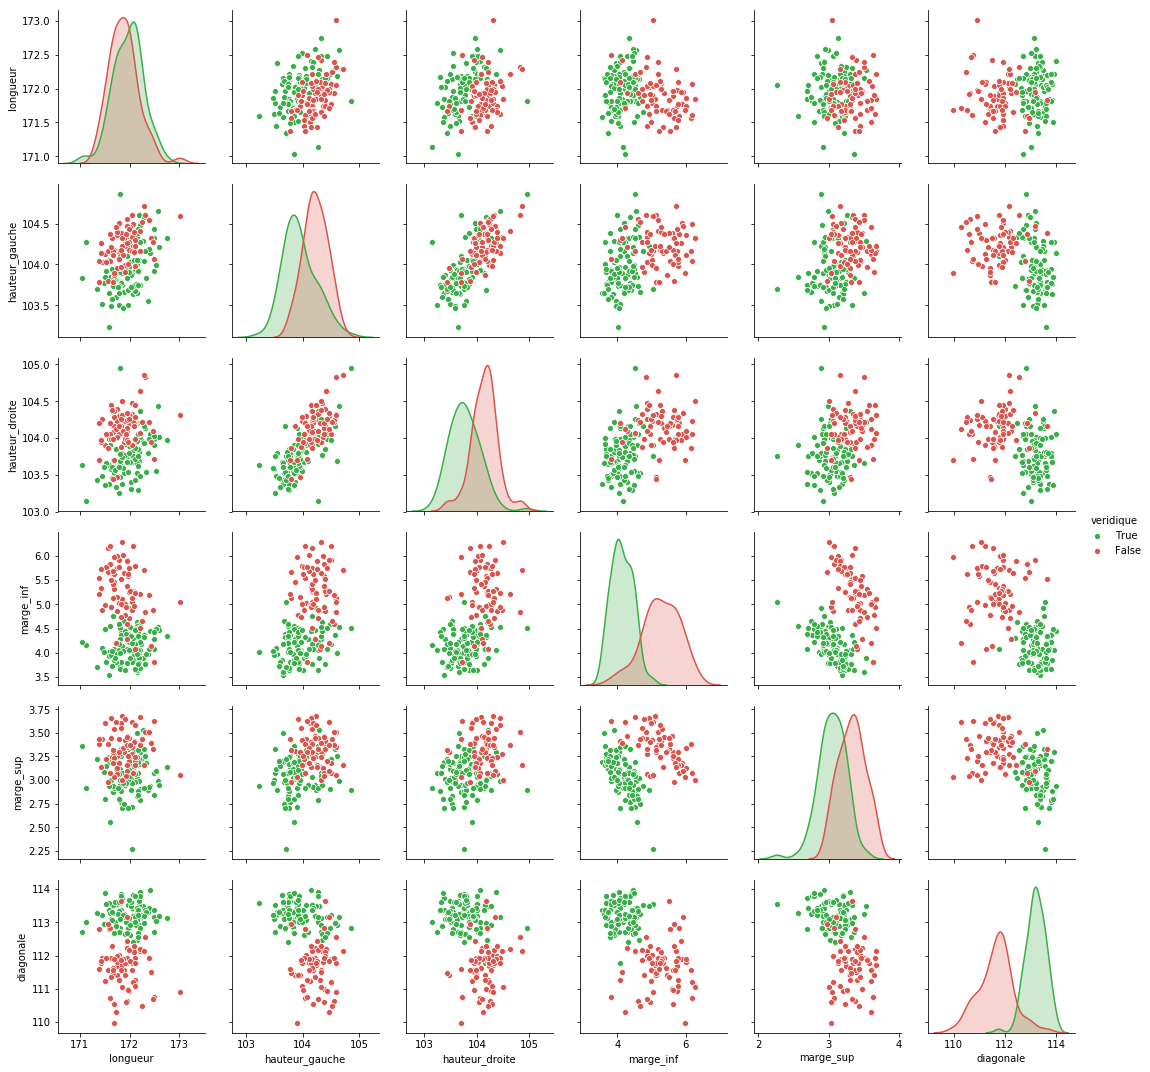

In [34]:
# Création d'une table temporaire
# On change le type de la colonne veridique
# d'un type "numpy.boolean" à un type "str"
df_billet_str = df_billet.copy()
df_billet_str.iloc[:,0] = df_billet_str.iloc[:,0].astype(str)

# On plot.
g = sns.pairplot(df_billet_str, hue="veridique",palette=ma_palette)
# On sauvegarde la figure
g.savefig('visuals/pairplot.png')

* **Analyse graphique du pairplot**
  * Les plots en lien avec la **marge inférieure** montrent que les billets non véridiques ont des marge inférieure plus élevées que les billets véridiques.
  * Les plots en lien avec la **diagonale** montrent que les billets non véridiques ont des diagonales plus faibles que les billets véridiques.

### Test ANOVA

Test ANOVA pour vérifier nos analyses graphiques.
* H0: Les moyennes des billets véridiques et non véridiques sont égales
* H1: Les moyennes ne sont pas égales.

In [35]:
# Variable quantitative
x = "diagonale"
# Variable qualitative
y = "veridique"

sample0 = df_billet[x][df_billet[y]]
sample1 = df_billet[x][~df_billet[y]]

FSTAT, pvalue = scipy.stats.f_oneway(sample0, sample1)
print("FSTAT = {}, pvalue = {}".format(
    round(FSTAT, 2),
    round(pvalue, 2)))
if pvalue < 0.05:
    print("On rejette H0.\nLes billets véridiques n'ont pas la même moyenne que les billets\
 non-véridiques pour la variable x: {} à un niveau de confiance de 95%.".format(x))
else:
    print("On ne peut pas rejetter H0. Les moyennes sont identiques à un niveau de confiance de 95%.")

FSTAT = 360.05, pvalue = 0.0
On rejette H0.
Les billets véridiques n'ont pas la même moyenne que les billets non-véridiques pour la variable x: diagonale à un niveau de confiance de 95%.


In [36]:
np.mean(sample0)

113.20720000000001

In [37]:
np.mean(sample1)

111.6607142857143

In [38]:
# Variable quantitative
x = "marge_inf"
# Variable qualitative
y = "veridique"

sample0 = df_billet[x][df_billet[y]]
sample1 = df_billet[x][~df_billet[y]]

FSTAT, pvalue = scipy.stats.f_oneway(sample0, sample1)
print("FSTAT = {}, pvalue = {}".format(
    round(FSTAT, 2),
    round(pvalue, 2)))
if pvalue < 0.05:
    print("On rejette H0.\nLes billets véridiques n'ont pas la même moyenne que les billets\
 non-véridiques pour la variable x: {} à un niveau de confiance de 95%.".format(x))
else:
    print("On ne peut pas rejetter H0. Les moyennes sont identiques à un niveau de confiance de 95%.")

FSTAT = 298.9, pvalue = 0.0
On rejette H0.
Les billets véridiques n'ont pas la même moyenne que les billets non-véridiques pour la variable x: marge_inf à un niveau de confiance de 95%.


In [39]:
np.mean(sample0)

4.143500000000002

In [40]:
np.mean(sample1)

5.281571428571428

In [41]:
# Variable quantitative
x = "longueur"
# Variable qualitative
y = "veridique"

sample0 = df_billet[x][df_billet[y]]
sample1 = df_billet[x][~df_billet[y]]

FSTAT, pvalue = scipy.stats.f_oneway(sample0, sample1)
print("FSTAT = {}, pvalue = {}".format(
    round(FSTAT, 2),
    round(pvalue, 2)))
if pvalue < 0.05:
    print("On rejette H0.\nLes billets véridiques n'ont pas la même moyenne que les billets\
 non-véridiques pour la variable x: {} à un niveau de confiance de 95%.".format(x))
else:
    print("On ne peut pas rejetter H0. \nLes moyennes sont identiques pour la variable x: {} à un niveau de confiance de 95%.".format(x))

FSTAT = 3.32, pvalue = 0.07
On ne peut pas rejetter H0. 
Les moyennes sont identiques pour la variable x: longueur à un niveau de confiance de 95%.


# Analyse en composantes principales

* Analyse de l'éboulis des valeurs propres
* Représentation des variables par le cercle des corrélations
* Représentation des individus par les plans factoriels
* Analyser la qualité de représentation et la contribution des individus.


## Fonctions

In [42]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:
            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 : # Si on a moins de 30 flèches.
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else : # Sinon on ajuste en fonction de la valeur des flèches.
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]), # origine des flèches
                   pcs[d1,:], pcs[d2,:], # Destinations des flêches.
                   angles='xy', scale_units='xy', scale=1, color="grey")
            #angle de la flêches #scale_unit longueur de la flêche.
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

## Préparation des données pour ACP

* **Composantes**: Nous avons 6 composantes principales.
* **Individus**: Nous avons 170 individus/billets.
* **Variable illustrative**: la variable "veridique" donnant la nature Vrai/Faux du billet.  
Les variables illustratives n'influencent pas la construction des composantes principales de l'analyse. Elles aident à l'interprétation des dimensions de variabilité.

In [43]:
# Les données pour l'ACP.
# On exclue la colonne "veracite".
# C'est une vue des données de la dataframe df_billet.
X = df_billet.iloc[:,1:]

# Centrage et Réduction
# "Standardize features by removing the mean and scaling to unit variance"
# fit "Compute the mean and std to be used for later scaling.""
# std_scale.mean_ to see the mean of the variables
std_scale = StandardScaler().fit(X)

#  Perform standardization by centering and scaling
# Contient nos valeurs standardisées.
# on aurait pu faire fit_transform.
X_scaled = std_scale.transform(X)

In [44]:
# On créé un objet de la classe PCA.
# fit(): Fit the model with X.
# n_components = None on garde toutes les variables.
pca = PCA(n_components=None).fit(X_scaled)

# transform: Apply dimensionality reduction to X.
# On passe de 7 dimensions à 2 dimensions.
X_projected = pca.transform(X_scaled)

# Directions des composantes principales.
pcs = pca.components_

In [45]:
# Les noms des composantes
# On a une array.
noms_colonnes = X.columns
composantes = np.array(noms_colonnes)

# Couleurs que nous allons utiliser pour colorer chaque point en fonction de sa véracité.
color = plt.get_cmap('tab10')

# On enregistre la véracité des billets
billets = df_billet.iloc[:, 0].values

## Eboulis des valeurs propres

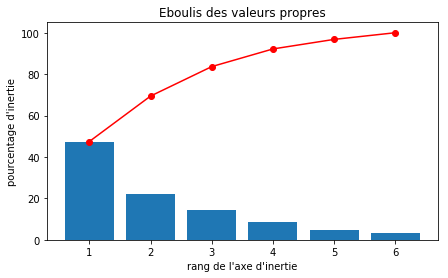

In [46]:
# Eboulis des valeurs propres
# initialisation de la figure
fig, ax = plt.subplots(figsize=(7,4))

display_scree_plot(pca)
# On sauvegarde la figure
fig.savefig('visuals/eboulis_des_valeurs_propres.png')

In [47]:
# Le pourcentage de variance expliqué par chaque composant ou axe (F1, F2,...)
# Similaire à l'éboulis des valeurs propres.
pca.explained_variance_ratio_

array([0.47447921, 0.21957106, 0.14234524, 0.08526295, 0.04612822,
       0.03221331])

## Cercle des corrélations

### Premier plan factoriel

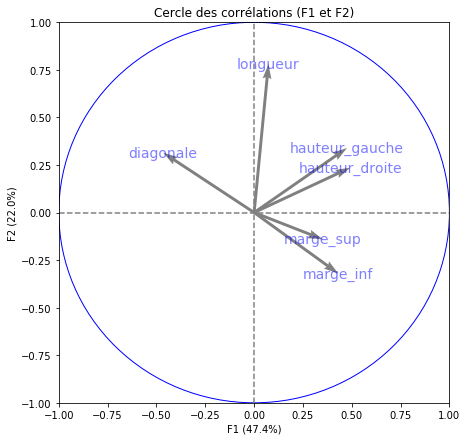

In [48]:
# Cercle des corrélations
# initialisation de la figure
fig, ax = plt.subplots(figsize=(7,7))
display_circles(pcs, 4, pca, [(0,1)], labels=composantes)
# On sauvegarde la figure
fig.savefig('visuals/cercle_des_correlations_premier_plan_factoriel.png')

### Deuxième plan factoriel

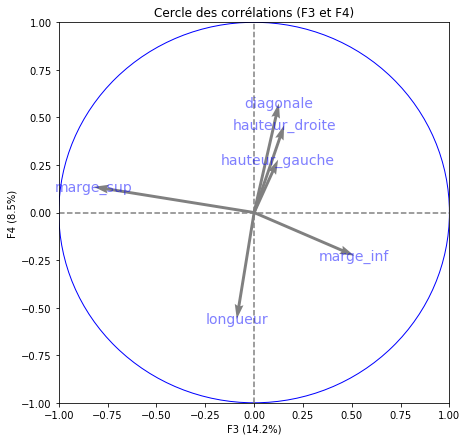

In [49]:
# Cercle des corrélations
# initialisation de la figure
fig, ax = plt.subplots(figsize=(7,7))
display_circles(pcs, 4, pca, [(2,3)], labels=composantes)
# On sauvegarde la figure
fig.savefig('visuals/cercle_des_correlations_deuxieme_plan_factoriel.png')

## Représentation des individus

Souhaitant projeter en deux couleurs différentes nos billets véridiques et nos billets non-véridiques, nous devons:  
* Séléctionner les données de X_projected
  * quand le billet est véridique
  * quand le billet n'est pas véridique

### Premier plan factoriel

In [50]:
# Axes associés à ce plan
axis_ranks = [(0,1)]

In [51]:
for d1, d2 in axis_ranks:
    x_true = X_projected[:,d1][df_billet["veridique"]]
    y_true = X_projected[:,d2][df_billet["veridique"]]
    x_false = X_projected[:,d1][~df_billet["veridique"]]
    y_false = X_projected[:,d2][~df_billet["veridique"]]

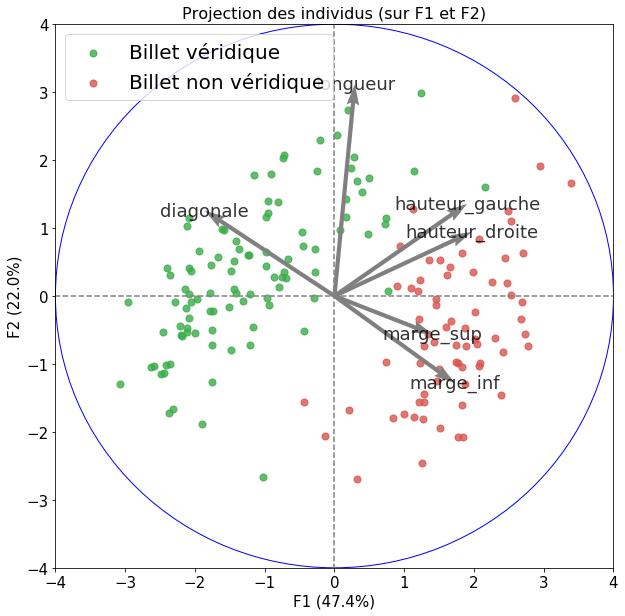

In [52]:
# Projection des individus
# Le plan factoriel que l'on souhaite voir
# Axes associés à ce plan
axis_ranks = [(0,1)]

# initialisation de la figure  
fig, ax = plt.subplots(figsize=(10,10))
ax.tick_params(labelsize=15)

for d1,d2 in axis_ranks:
    ax.scatter(x_true,y_true, c=vert, alpha=.8, label="Billet véridique",s=50)
    ax.scatter(x_false,y_false, c=rouge, alpha=.8, label="Billet non véridique",s=50)
    # s taille marker. # Label pour la légende
        
    legend = ax.legend(fontsize=20)   

    # détermination des limites du graphique
    # On va baser le cercle sur ces mesures donc on doit lim_x = lim_y
    graph_lim = 4
    plt.xlim([-graph_lim,graph_lim]) #-boundary,boundary
    plt.ylim([-graph_lim,graph_lim]) #-boundary,boundary
    
    # affichage des lignes horizontales et verticales
    plt.plot([-100, 100], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-100, 100], color='grey', ls='--')

    # nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)), fontsize=15)
    plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)), fontsize=15)
    
    plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1), fontsize=16)
    
    
    # affichage des noms des composantes
    labels = composantes
    for i,(x, y) in enumerate(pcs[[d1,d2]].T):
        plt.text(x*graph_lim, y*graph_lim, labels[i], fontsize='18', ha='center', va='center', color="black", alpha=0.8)
    
    # affichage des flèches
    # https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html
    plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]), # origine des flèches
       pcs[d1,:]*graph_lim, pcs[d2,:]*graph_lim, # Destinations des flêches.
       angles='xy', scale_units='xy', scale=1, color="grey")
    #angle de la flêches #scale_unit longueur de la flêche.
    
    # affichage du cercle
    circle = plt.Circle((0,0), 1*graph_lim, facecolor='none', edgecolor='b')
    plt.gca().add_artist(circle)
    # On sauvegarde la figure
    fig.savefig('visuals/projection_individus_premier_plan_factoriel.png')

plt.show(block=False)

In [53]:
# Correlation entre les composants principaux FX et les variables.
# composantes = noms des colonnes explicatives.
# pca_components_ : matrice des correlations.
matrice_correlation = pd.DataFrame(pca.components_, columns=composantes,index = ['F1','F2','F3','F4','F5','F6'])
print(matrice_correlation)

    longueur  hauteur_gauche  hauteur_droite  marge_inf  marge_sup  diagonale
F1  0.073275        0.475502        0.491821   0.431027   0.352540  -0.465373
F2  0.779639        0.339250        0.235543  -0.320537  -0.141120   0.314536
F3 -0.088894        0.122760        0.153830   0.512808  -0.821149   0.126913
F4 -0.559732        0.278046        0.458938  -0.226528   0.135340   0.573703
F5 -0.225094        0.715921       -0.486993  -0.311908  -0.193943  -0.254417
F6  0.122166        0.232131       -0.480813   0.547630   0.354380   0.523951


### Deuxième plan factoriel

In [54]:
# Axes associés à ce plan
axis_ranks = [(2,3)]

In [55]:
for d1, d2 in axis_ranks:
    x_true = X_projected[:,d1][df_billet["veridique"]]
    y_true = X_projected[:,d2][df_billet["veridique"]]
    x_false = X_projected[:,d1][~df_billet["veridique"]]
    y_false = X_projected[:,d2][~df_billet["veridique"]]

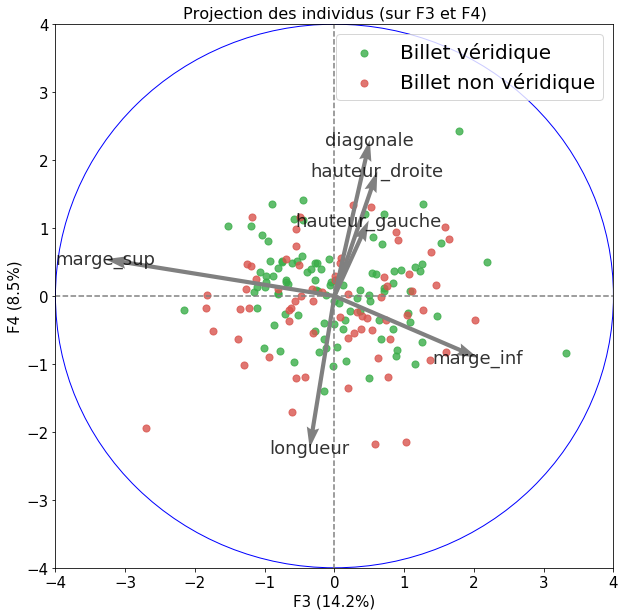

In [56]:
# Projection des individus
# Le plan factoriel que l'on souhaite voir
# initialisation de la figure  
fig, ax = plt.subplots(figsize=(10,10))
ax.tick_params(labelsize=15)

for d1,d2 in axis_ranks:
    ax.scatter(x_true,y_true, c=vert, alpha=.8, label="Billet véridique",s=50)
    ax.scatter(x_false,y_false, c=rouge, alpha=.8, label="Billet non véridique",s=50)
    # s taille marker. # Label pour la légende
        
    legend = ax.legend(fontsize=20)   

    # détermination des limites du graphique
    # On va baser le cercle sur ces mesures donc on doit lim_x = lim_y
    graph_lim = 4
    plt.xlim([-graph_lim,graph_lim]) #-boundary,boundary
    plt.ylim([-graph_lim,graph_lim]) #-boundary,boundary
    
    # affichage des lignes horizontales et verticales
    plt.plot([-100, 100], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-100, 100], color='grey', ls='--')

    # nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)), fontsize=15)
    plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)), fontsize=15)
    
    plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1), fontsize=16)
    
    
    # affichage des noms des composantes
    labels = composantes
    for i,(x, y) in enumerate(pcs[[d1,d2]].T):
        plt.text(x*graph_lim, y*graph_lim, labels[i], fontsize='18', ha='center', va='center', color="black", alpha=0.8)
    
    # affichage des flèches
    # https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html
    plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]), # origine des flèches
       pcs[d1,:]*graph_lim, pcs[d2,:]*graph_lim, # Destinations des flêches.
       angles='xy', scale_units='xy', scale=1, color="grey")
    #angle de la flêches #scale_unit longueur de la flêche.
    
    # affichage du cercle
    circle = plt.Circle((0,0), 1*graph_lim, facecolor='none', edgecolor='b')
    plt.gca().add_artist(circle)
    # On sauvegarde la figure
    fig.savefig('visuals/projection_individus_deuxieme_plan_factoriel.png')

## Analyse de la qualité de représentation et de la contribution des individus

* **Qualité de la représentation**:
    * Dans le premier plan factoriel, on peut voir que les individus sont bien représentés car ils sont groupés par couleur. De plus les axes F1 et F2 expliquent une grande partie du pourcentage d'inertie (22% et 44%).
    * Dans le second plan factoriel, ce n'est plus le cas.  

**C'est pourquoi, on interprétera seulement la projection des individus dans le premier plan factoriel.**

* **Contribution des individus**:  
Lors du calcul des composantes principales, chaque individu est pris en compte.  
Cependant, certains influent plus que d’autres sur le calcul de certaines composantes.  
Il arrive parfois qu’un axe ne soit dû principalement qu’à un tout petit groupe d’individus, voire qu’à un seul.
Cela signifie que quelques individus « attirent » fortement un axe dans leur direction, quasiment sans laisser les autres individus contribuer à la formation de cet axe.  
Cependant, ce n'est pas notre cas. En effet, nous n'avons pas de point ou d'outlier avec des valeurs telles qu'ils attirent à eux seul les axes. On peut le voir via la projection des individus.

In [57]:
pca.singular_values_ 

array([21.99929067, 14.96537607, 12.04957045,  9.32567496,  6.85935776,
        5.73215306])

# Analyse de la classification

## Dendrogramme

**Clustering hiérarchique**  
On ne précise pas le nombre de cluster que l'on souhaite.  
On utilise la méthode de *ward* pour créer notre classification hiérarchique.  
On aurait pu utiliser la méthode *centroid*.

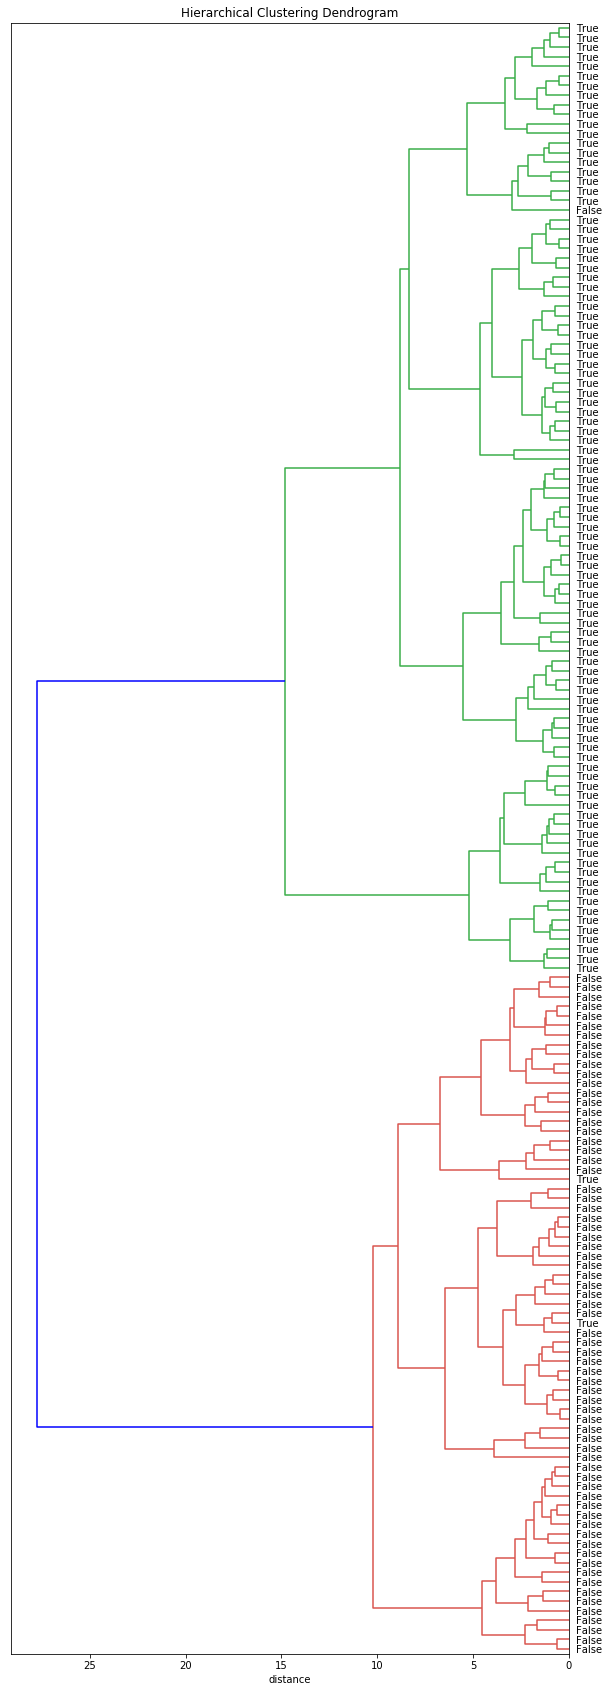

In [58]:
Z = scipy.cluster.hierarchy.linkage(X_scaled, method='ward')
# Pour obtenir la bonne couleur.
scipy.cluster.hierarchy.set_link_color_palette([rouge, vert])
# Affichage du dendrogramme
plt.figure(figsize=(10, 30))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('distance')
r_dict = scipy.cluster.hierarchy.dendrogram(Z,labels=billets,orientation="left",leaf_font_size=10, color_threshold=15)
# On sauvegarde la figure avec 2 clusters visibles
plt.savefig('visuals/dendrogramme_2_clusters.png')
plt.show()

Pour l’ensemble de nos observations, on a une **valeur observée** "veridique" et une **valeur prédite** "dendrogramme".

In [59]:
# On ajoute une colonne à notre dataframe pour comparer les résultats obtenus.
# Les données sont enregistrées du premier au dernier node
# On inverse les donnees.
dendrogramme_resultat = r_dict["ivl"]
dendrogramme_resultat_inverse = dendrogramme_resultat[::-1]
df_billet["dendogramme"] = dendrogramme_resultat_inverse

### Indicateurs

**Indicateurs:**
* **Exactitude**: La fraction de vrais positifs et vrais négatifs.
* **Précision**: ratio vrais_positifs/(vrais_positifs + faux_positifs). La capacité du model à ne pas labeler positif un individus qui est négatif.
* **Sensibilité**:  ratio vrais_positifs/(vrais_positifs + faux_negatifs). La capacité du model à trouver tous les individus positifs.
* **Spécifité**:  ratio vrais_negatifs/(vrais_negatifs + faux_positifs). La capacité du model à trouver tous les individus négatifs.

In [60]:
# Pour calculer nos indicateurs et projeter les individus.
x_vrai_positif = X_projected[:,0][(df_billet["veridique"] & df_billet["dendogramme"])]
y_vrai_positif = X_projected[:,1][(df_billet["veridique"] & df_billet["dendogramme"])]

x_faux_positif = X_projected[:,0][(~df_billet["veridique"] & df_billet["dendogramme"])]
y_faux_positif = X_projected[:,1][(~df_billet["veridique"] & df_billet["dendogramme"])]

x_vrai_negatif = X_projected[:,0][(~df_billet["veridique"] & (~df_billet["dendogramme"]))]
y_vrai_negatif = X_projected[:,1][(~df_billet["veridique"] & (~df_billet["dendogramme"]))]

x_faux_negatif = X_projected[:,0][(df_billet["veridique"] & (~df_billet["dendogramme"]))]
y_faux_negatif = X_projected[:,1][(df_billet["veridique"] & (~df_billet["dendogramme"]))]

In [61]:
# On calcule le nombre de vrai/faux positif/negatif.
nb_vrai_positif = x_vrai_positif.shape[0]
nb_vrai_negatif = x_vrai_negatif.shape[0]
nb_faux_positif = x_faux_positif.shape[0]
nb_faux_negatif = x_faux_negatif.shape[0]

In [62]:
exactitude = round((nb_vrai_positif + nb_vrai_negatif) / (nb_veridique + nb_non_veridique),2)
precision = round(nb_vrai_positif / (nb_vrai_positif + nb_faux_positif),2)
sensibilite = round(nb_vrai_positif / (nb_vrai_positif + nb_faux_negatif),2)
specificite = round(nb_vrai_negatif / (nb_vrai_negatif + nb_faux_positif),2)


In [63]:
print("Exactitude:",exactitude)
print("Précision:",precision)
print("Sensibilité:",sensibilite)
print("Spécificité:",specificite)

Exactitude: 0.98
Précision: 0.98
Sensibilité: 0.98
Spécificité: 0.97


### Visualisation

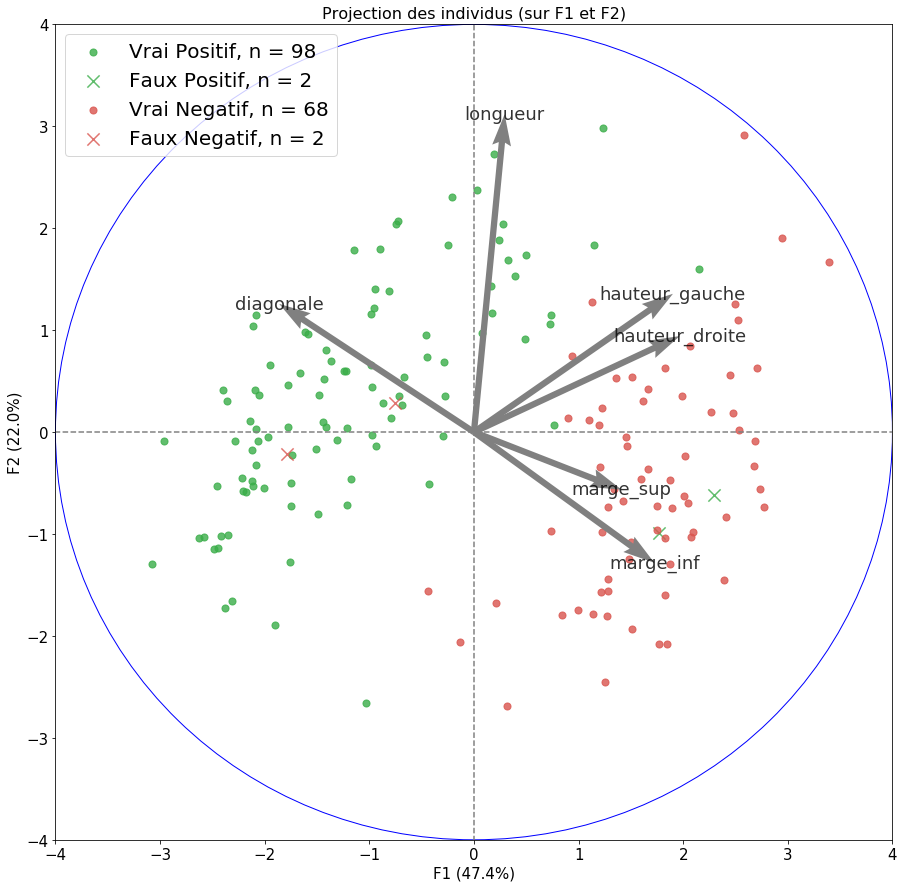

In [64]:
# Projection des individus
# Le plan factoriel que l'on souhaite voir
# Axes associés à ce plan
axis_ranks = [(0, 1)]

# initialisation de la figure
fig, ax = plt.subplots(figsize=(15, 15))
ax.tick_params(labelsize=15)

for d1, d2 in axis_ranks:
    ax.scatter(x_vrai_positif, y_vrai_positif, c=vert, alpha=.8,
               label="Vrai Positif, n = {}".format(nb_vrai_positif), s=50)
    ax.scatter(x_faux_positif, y_faux_positif, c=vert, alpha=.8,
               marker="x", label="Faux Positif, n = {}".format(nb_faux_positif), s=150)
    ax.scatter(x_vrai_negatif, y_vrai_negatif, c=rouge,
               alpha=.8, label="Vrai Negatif, n = {}".format(nb_vrai_negatif), s=50)
    ax.scatter(x_faux_negatif, y_faux_negatif, c=rouge,
               alpha=.8, marker="x", label="Faux Negatif, n = {}".format(nb_faux_negatif), s=150)
    # s taille marker. # Label pour la légende

    legend = ax.legend(fontsize=20)

    # détermination des limites du graphique
    # On va baser le cercle sur ces mesures donc on doit lim_x = lim_y
    graph_lim = 4
    plt.xlim([-graph_lim, graph_lim])  # -boundary,boundary
    plt.ylim([-graph_lim, graph_lim])  # -boundary,boundary

    # affichage des lignes horizontales et verticales
    plt.plot([-100, 100], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-100, 100], color='grey', ls='--')

    # nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(
        d1+1, round(100*pca.explained_variance_ratio_[d1], 1)), fontsize=15)
    plt.ylabel('F{} ({}%)'.format(
        d2+1, round(100*pca.explained_variance_ratio_[d2], 1)), fontsize=15)

    plt.title("Projection des individus (sur F{} et F{})".format(
        d1+1, d2+1), fontsize=16)

    # affichage des noms des composantes
    labels = composantes
    for i, (x, y) in enumerate(pcs[[d1, d2]].T):
        plt.text(x*graph_lim, y*graph_lim,
                 labels[i], fontsize='18', ha='center', va='center', color="black", alpha=0.8)

    # affichage des flèches
    # https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html
    plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),  # origine des flèches
               # Destinations des flêches.
               pcs[d1, :]*graph_lim, pcs[d2, :]*graph_lim,
               angles='xy', scale_units='xy', scale=1, color="grey")
    # angle de la flêches #scale_unit longueur de la flêche.

    # affichage du cercle
    circle = plt.Circle((0, 0), 1*graph_lim, facecolor='none', edgecolor='b')
    plt.gca().add_artist(circle)
    # On sauvegarde la figure
    fig.savefig('visuals/projection_individus_premier_plan_factoriel_dendrogramme.png')

plt.show(block=False)

## Clustering K-means

Pour l’ensemble de nos observations, on a une **valeur observée** "veridique" et une **valeur prédite** "k_means".

**Clustering par K-means**
+ Plus rapide
+ Pas reproductible car choix des centroïd différents.

In [65]:
n_clust = 2
km = KMeans(n_clusters=n_clust) #On créé un objet nommé "km" de la class KMeans
km.fit(X_scaled) #Compute k-means clustering.
# Récupération des clusters attribués à chaque billet
clusters = km.labels_
# Transformation des valeurs 0 et 1 en boolean False et True
# Le premier cluster "0" correspond à la première valeur.
# Regarderons la taille des deux clusters afin de savoir lequel est celui pour les valeurs True.
valeurs_uniques, compte_des_valeurs_uniques = np.unique(clusters, return_counts=True)
# On sélectionne le cluster
cluster_true = [index for index in valeurs_uniques if compte_des_valeurs_uniques[index] == max(compte_des_valeurs_uniques)]
# On transforme la liste en entier
cluster_true = cluster_true[0]
k_mean_result = [True if num == cluster_true else False for num in clusters]
# Récupération des centroids des clusters avant réduction des dimensions.
centroids = np.array(km.cluster_centers_)

In [66]:
# On ajoute une colonne à notre dataframe pour comparer les résultats obtenus.
df_billet["k_mean"]=k_mean_result
df_billet.head(10)

,veridique,longueur,hauteur_gauche,hauteur_droite,marge_inf,marge_sup,diagonale,dendogramme,k_mean
0,True,171.81,104.86,104.95,4.52,2.89,112.83,True,False
1,True,171.67,103.74,103.70,4.01,2.87,113.29,True,True
2,True,171.83,103.76,103.76,4.40,2.88,113.84,True,True
3,True,171.80,103.78,103.65,3.73,3.12,113.63,True,True
4,True,172.05,103.70,103.75,5.04,2.27,113.55,True,True
5,True,172.57,104.65,104.44,4.54,2.99,113.16,True,False
6,True,172.38,103.55,103.80,3.97,2.90,113.30,True,True
7,True,171.58,103.65,103.37,3.54,3.19,113.38,True,True
8,True,171.96,103.51,103.75,4.06,3.33,113.53,True,True
9,True,172.14,104.34,104.20,4.63,3.02,112.47,True,False


### Indicateurs

**Indicateurs:**
* **Exactitude**: La fraction de vrais positifs et vrais négatifs.
* **Précision**: ratio vrais_positifs/(vrais_positifs + faux_positifs). La capacité du model à ne pas labeler positif un individus qui est négatif.
* **Sensibilité**:  ratio vrais_positifs/(vrais_positifs + faux_negatifs). La capacité du model à trouver tous les individus positifs.
* **Spécifité**:  ratio vrais_negatifs/(vrais_negatifs + faux_positifs). La capacité du model à trouver tous les individus négatifs.

In [67]:
# Pour calculer nos indicateurs et projeter les individus.
x_vrai_positif = X_projected[:,0][(df_billet["veridique"] & df_billet["k_mean"])]
y_vrai_positif = X_projected[:,1][(df_billet["veridique"] & df_billet["k_mean"])]

x_faux_positif = X_projected[:,0][(~df_billet["veridique"] & df_billet["k_mean"])]
y_faux_positif = X_projected[:,1][(~df_billet["veridique"] & df_billet["k_mean"])]

x_vrai_negatif = X_projected[:,0][(~df_billet["veridique"] & (~df_billet["k_mean"]))]
y_vrai_negatif = X_projected[:,1][(~df_billet["veridique"] & (~df_billet["k_mean"]))]

x_faux_negatif = X_projected[:,0][(df_billet["veridique"] & (~df_billet["k_mean"]))]
y_faux_negatif = X_projected[:,1][(df_billet["veridique"] & (~df_billet["k_mean"]))]

In [68]:
# On calcule le nombre de vrai/faux positif/negatif.
nb_vrai_positif = x_vrai_positif.shape[0]
nb_vrai_negatif = x_vrai_negatif.shape[0]
nb_faux_positif = x_faux_positif.shape[0]
nb_faux_negatif = x_faux_negatif.shape[0]

In [69]:
exactitude = round((nb_vrai_positif + nb_vrai_negatif) / (nb_veridique + nb_non_veridique),2)
precision = round(nb_vrai_positif / (nb_vrai_positif + nb_faux_positif),2)
sensibilite = round(nb_vrai_positif / (nb_vrai_positif + nb_faux_negatif),2)
specificite = round(nb_vrai_negatif / (nb_vrai_negatif + nb_faux_positif),2)


In [70]:
print("Exactitude:",exactitude)
print("Précision:",precision)
print("Sensibilité:",sensibilite)
print("Spécificité:",specificite)

Exactitude: 0.95
Précision: 0.99
Sensibilité: 0.93
Spécificité: 0.99


### Visualisation

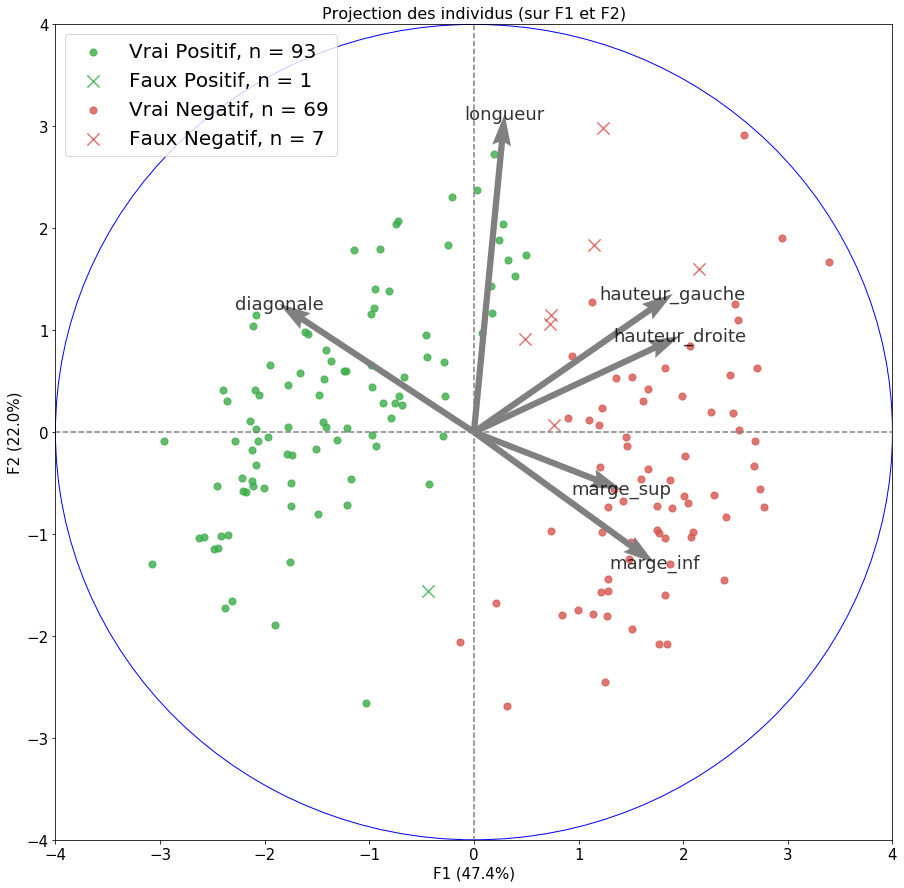

In [71]:
# Projection des individus
# Le plan factoriel que l'on souhaite voir
# Axes associés à ce plan
axis_ranks = [(0, 1)]

# initialisation de la figure
fig, ax = plt.subplots(figsize=(15, 15))
ax.tick_params(labelsize=15)

for d1, d2 in axis_ranks:
    ax.scatter(x_vrai_positif, y_vrai_positif, c=vert, alpha=.8,
               label="Vrai Positif, n = {}".format(nb_vrai_positif), s=50)
    ax.scatter(x_faux_positif, y_faux_positif, c=vert, alpha=.8,
               marker="x", label="Faux Positif, n = {}".format(nb_faux_positif), s=150)
    ax.scatter(x_vrai_negatif, y_vrai_negatif, c=rouge,
               alpha=.8, label="Vrai Negatif, n = {}".format(nb_vrai_negatif), s=50)
    ax.scatter(x_faux_negatif, y_faux_negatif, c=rouge,
               alpha=.8, marker="x", label="Faux Negatif, n = {}".format(nb_faux_negatif), s=150)
    # s taille marker. # Label pour la légende

    legend = ax.legend(fontsize=20)

    # détermination des limites du graphique
    # On va baser le cercle sur ces mesures donc on doit lim_x = lim_y
    graph_lim = 4
    plt.xlim([-graph_lim, graph_lim])  # -boundary,boundary
    plt.ylim([-graph_lim, graph_lim])  # -boundary,boundary

    # affichage des lignes horizontales et verticales
    plt.plot([-100, 100], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-100, 100], color='grey', ls='--')

    # nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(
        d1+1, round(100*pca.explained_variance_ratio_[d1], 1)), fontsize=15)
    plt.ylabel('F{} ({}%)'.format(
        d2+1, round(100*pca.explained_variance_ratio_[d2], 1)), fontsize=15)

    plt.title("Projection des individus (sur F{} et F{})".format(
        d1+1, d2+1), fontsize=16)

    # affichage des noms des composantes
    labels = composantes
    for i, (x, y) in enumerate(pcs[[d1, d2]].T):
        plt.text(x*graph_lim, y*graph_lim,
                 labels[i], fontsize='18', ha='center', va='center', color="black", alpha=0.8)

    # affichage des flèches
    # https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html
    plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),  # origine des flèches
               # Destinations des flêches.
               pcs[d1, :]*graph_lim, pcs[d2, :]*graph_lim,
               angles='xy', scale_units='xy', scale=1, color="grey")
    # angle de la flêches #scale_unit longueur de la flêche.

    # affichage du cercle
    circle = plt.Circle((0, 0), 1*graph_lim, facecolor='none', edgecolor='b')
    plt.gca().add_artist(circle)
    # On sauvegarde la figure
    fig.savefig('visuals/projection_individus_premier_plan_factoriel_kmean.png')

plt.show(block=False)

# Régression logistique

## Rappel sur la regréssion logistique

**Source**: https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

**Properties of Logistic Regression**:
* The dependent variable in logistic regression follows Bernoulli Distribution.
* Estimation is done through maximum likelihood.
* No R Square, Model fitness is calculated through Concordance, KS-Statistics.


**Maximum Likelihood Estimation (MLE)** approach.  
The MLE is a "likelihood" maximization method.  
From a statistical point of view, MLE sets the mean and variance as parameters in determining the specific parametric values for a given model. This set of parameters can be used for predicting the data needed in a normal distribution.

**Sigmoid Function**

The sigmoid function, also called logistic function gives an ‘S’ shaped curve that can take any real-valued number and map it into a value between 0 and 1. If the curve goes to positive infinity, y predicted will become 1, and if the curve goes to negative infinity, y predicted will become 0. If the output of the sigmoid function is more than 0.5, we can classify the outcome as 1 or YES, and if it is less than 0.5, we can classify it as 0 or NO. The outputcannotFor example: If the output is 0.75, we can say in terms of probability as: There is a 75 percent chance that patient will suffer from cancer.

**Binary Logistic Regression**  
The target variable has only two possible outcomes such as Spam or Not Spam, Cancer or No Cancer.

**Advantages**  
Because of its efficient and straightforward nature, doesn't require high computation power, easy to implement, easily interpretable, used widely by data analyst and scientist.  
Also, it doesn't require scaling of features. Logistic regression provides a probability score for observations. 

**Disadvantages**  
Logistic regression is not able to handle a large number of categorical features/variables.  
It is vulnerable to overfitting.  
Can't solve the non-linear problem with the logistic regression that is why it requires a transformation of non-linear features.  
Logistic regression will not perform well with independent variables that are not correlated to the target variable and are very similar or correlated to each other.

## Préparation des données

### Variables explicates vs Variable expliquée

In [72]:
df_billet.head()

,veridique,longueur,hauteur_gauche,hauteur_droite,marge_inf,marge_sup,diagonale,dendogramme,k_mean
0,True,171.81,104.86,104.95,4.52,2.89,112.83,True,False
1,True,171.67,103.74,103.70,4.01,2.87,113.29,True,True
2,True,171.83,103.76,103.76,4.40,2.88,113.84,True,True
3,True,171.80,103.78,103.65,3.73,3.12,113.63,True,True
4,True,172.05,103.70,103.75,5.04,2.27,113.55,True,True


In [73]:
# Variables explicatives
X = df_billet.iloc[:,1:7]
# Variables expliquées
y = df_billet["veridique"]

### Séparation des données

* Séparation des données entre:
  * Les données pour entrainer notre modèle, 70% de nos données.
  * Les données pour tester notre modèle, 30% de nos données.

In [74]:
# random_state: seed utilisé pour la sélection aléatoire.
X_entrainement,X_test,y_entrainement,y_test=sklearn.model_selection.train_test_split(X,y,test_size=0.30,random_state=100)

### Algorithme SMOTE

* But: Balancer la proportion de billets véridiques et de billets non-véridiques dans nos données d'entrainement.
* Son utilité:
    1. Créé des copies syntétiques de la classe la plus faible, au lieu de créer des copies.
    2. Choisie de manière aléatoire un des k_nearest_neighbors, et l'utilise pour créer des observations nouvelles, similaires mais légèrement modifiées

In [75]:
# On vérifie nos données
print("Avant nombre de billets non véridiques:",len(y_entrainement[y_entrainement==0]))
print("Avant nombre de billets véridiques:",len(y_entrainement[y_entrainement==1]))
print("Avant proportion de billets non-véridiques:",len(y_entrainement[y_entrainement==0])/len(X_entrainement))
print("Avant proportion de billets véridiques:",len(y_entrainement[y_entrainement==1])/len(X_entrainement))

Avant nombre de billets non véridiques: 48
Avant nombre de billets véridiques: 71
Avant proportion de billets non-véridiques: 0.40336134453781514
Avant proportion de billets véridiques: 0.5966386554621849


In [76]:
# Création d'un objet de la classe SMOTE.
os = SMOTE(random_state=0)

# Lancement de l'algorithme.
os_data_X,os_data_y=os.fit_sample(X_entrainement, y_entrainement)

# Création des df associées à nos valeurs d'entrainement.
colonnes = X_entrainement.columns
os_data_X = pd.DataFrame(data=os_data_X,columns=colonnes)
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

# On vérifie nos données
print("Nombre de billets non véridiques:",len(os_data_y[os_data_y['y']==0]))
print("Nombre de billets véridiques:",len(os_data_y[os_data_y['y']==1]))
print("Proportion de billets non-véridiques:",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion de billets véridiques:",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

Nombre de billets non véridiques: 71
Nombre de billets véridiques: 71
Proportion de billets non-véridiques: 0.5
Proportion de billets véridiques: 0.5


Nos données pour entrainer notre modèle.

In [77]:
X_entrainement = os_data_X
y_entrainement = os_data_y

## Développement du modèle et prédiction

In [78]:
# On créé un objet de la classe Logistic Regression.
notre_modele = LogisticRegression()

# On créé notre modele.
# On l'entraine avec nos données d'entrainement
y_entrainement_array = y_entrainement.iloc[:,0].values
notre_modele.fit(X_entrainement, y_entrainement_array)

# On fait la prédiction
# avec .predict()
y_pred = notre_modele.predict(X_test)

C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Evaluation du modèle

### Matrice de confusion

* Table pour visualiser la performance de notre modèle. Elle comprend:
  * Le nombre de prédictions corrects
  * Le nombre de prédictions incorrects

In [79]:
# On créé un objet de la classe metrics.
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[21,  1],
       [ 1, 28]], dtype=int64)

### Heatmap

* On visualise cette table avec une heatmap.

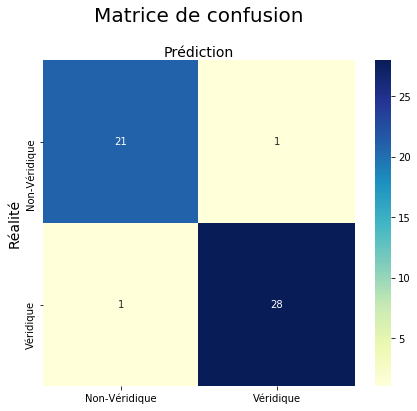

In [80]:
# Noms des classes
fig, ax = plt.subplots(figsize=(7, 6))

# Création heatmap
g = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Matrice de confusion', y=1.1, fontsize=20)

# Axis
# Labels
ax.set_ylabel('Réalité', fontsize=14)
ax.set_xlabel('Prédiction', fontsize=14)

# Ticks
# Noms des ticks
class_names=["Non-Véridique","Véridique"]
#g.set(yticklabels=["Non-Véridique","Véridique"])
#g.set(xticklabels=["Non-Véridique","Véridique"])

# Positions des ticks
ax.tick_params(labelsize=10)
test = np.arange(len(class_names))
plt.xticks(test+0.5, class_names)
plt.yticks(test+0.5, class_names)

# On sauvegarde la figure
fig.savefig('visuals/heatmap.png')

# On montre la figure.
plt.show()

### Indicateurs Matrice de confusion

**Indicateurs:**
* **Exactitude**: La fraction de vrais positifs et vrais négatifs.
* **Précision**: ratio vrais_positifs/(vrais_positifs + faux_positifs). La capacité du model à ne pas labeler positif un individus qui est négatif.
* **Sensibilité**:  ratio vrais_positifs/(vrais_positifs + faux_negatifs). La capacité du model à trouver tous les individus positifs.
* **Spécifité**:  ratio vrais_negatifs/(vrais_negatifs + faux_positifs). La capacité du model à trouver tous les individus négatifs.
    

In [81]:
exactitude = round(metrics.accuracy_score(y_test, y_pred),2)
precision = round(metrics.precision_score(y_test, y_pred),2)
sensibilite = round(metrics.recall_score(y_test, y_pred),2)
specificite = round((cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1])),2)

In [82]:
print("Exactitude:",exactitude)
print("Précision:",precision)
print("Sensibilité:",sensibilite)
print("Spécificité:",specificite)

Exactitude: 0.96
Précision: 0.97
Sensibilité: 0.97
Spécificité: 0.95


### Courbe ROC

La **fonction d’efficacité du récepteur**, plus fréquemment désignée sous le terme « **courbe ROC**», dite aussi caractéristique de performance (d'un test) ou courbe sensibilité/spécificité, est une mesure de la performance d'un classificateur binaire.  
Graphiquement, on représente souvent la mesure ROC sous la forme d'une courbe qui donne le taux de vrais positifs en fonction du taux de faux positifs.  
Un **score AUC** de 1 représente un classificateur parfait, un score de 0.5 représente un classificateur inutile.

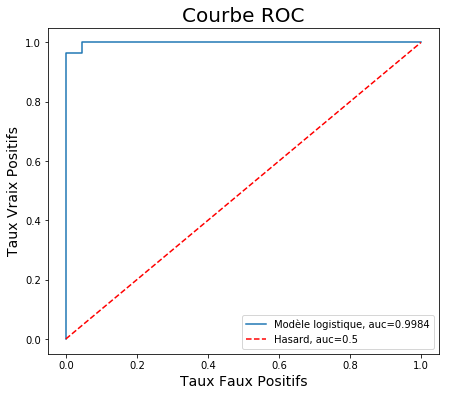

In [83]:
fig, ax = plt.subplots(figsize=(7, 6))
y_pred_proba = notre_modele.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = round(metrics.roc_auc_score(y_test, y_pred_proba),4)
plt.plot(fpr,tpr,label="Modèle logistique, auc="+str(auc))
x = [0,1]
y = [0,1]
plt.plot(x,y,"r--",label="Hasard, auc=0.5")
plt.legend(loc=4)


plt.title('Courbe ROC', fontsize=20)

# Axis
# Labels
ax.set_ylabel('Taux Vraix Positifs', fontsize=14)
ax.set_xlabel('Taux Faux Positifs', fontsize=14)
plt.show()
# On sauvegarde la figure
fig.savefig('visuals/courbe_roc.png')

# Programme pour effectuer une prédiction sur un billet

 Pour chaque billet, l'algorithme de classification devra donner la probabilité que le billet soit vrai. Si cette probabilité est supérieure ou égale à 0.5, le billet sera considéré comme vrai. Dans le cas contraire, il sera considéré comme faux.

In [84]:
# exemple : "exemple.csv"
nom_fichier_a_predire = "exemple.csv"

In [85]:
df_data = pd.read_csv(nom_fichier_a_predire)
nouveaux_noms_colonnes = {"length": "longueur", "height_left": "hauteur_gauche",
                          "height_right": "hauteur_droite",
                          "margin_low": "marge_inf", "margin_up": "marge_sup", "diagonal": "diagonale"}
df_data.rename(columns=nouveaux_noms_colonnes, inplace=True)

In [86]:
# Données pour la prédiction
X_a_predire = df_data.iloc[:, 0:6]
# Prédiction avec notre modèle.
y_pred = notre_modele.predict(X_a_predire)
proba_true = notre_modele.predict_proba(X_a_predire)[:, 1]
# Ajout d'une colonne avec la pobabilité que le sample soit vrai selon la prédiction
df_data["proba_veridique"] = np.round(proba_true, 2)
# Ajout d'une colonne avec la prédiction
df_data["prediction_veridique"] = y_pred

In [87]:
df_data

,longueur,hauteur_gauche,hauteur_droite,marge_inf,marge_sup,diagonale,id,proba_veridique,prediction_veridique
0,171.76,104.01,103.54,5.21,3.30,111.42,B_1,0.04,False
1,171.87,104.17,104.13,6.00,3.31,112.09,B_2,0.01,False
2,172.00,104.58,104.29,4.99,3.39,111.57,B_3,0.02,False
3,172.49,104.55,104.34,4.44,3.03,113.20,B_4,0.85,True
4,171.65,103.63,103.56,3.77,3.16,113.33,B_5,1.00,True
